In [30]:
library(extrafont)
library(tidyverse)
library(epidemia)
library(arrow)

# 1. parameters

In [31]:
T0 = 40

## observation parameters

In [32]:
alpha = 0.01

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [33]:
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{-T_0} = \mu_0$$

In [34]:
param <- read_feather('data/param_ebcr_1.feather')

In [35]:
names(param) <- c('region', 'mu', 'beta0', 'beta1')

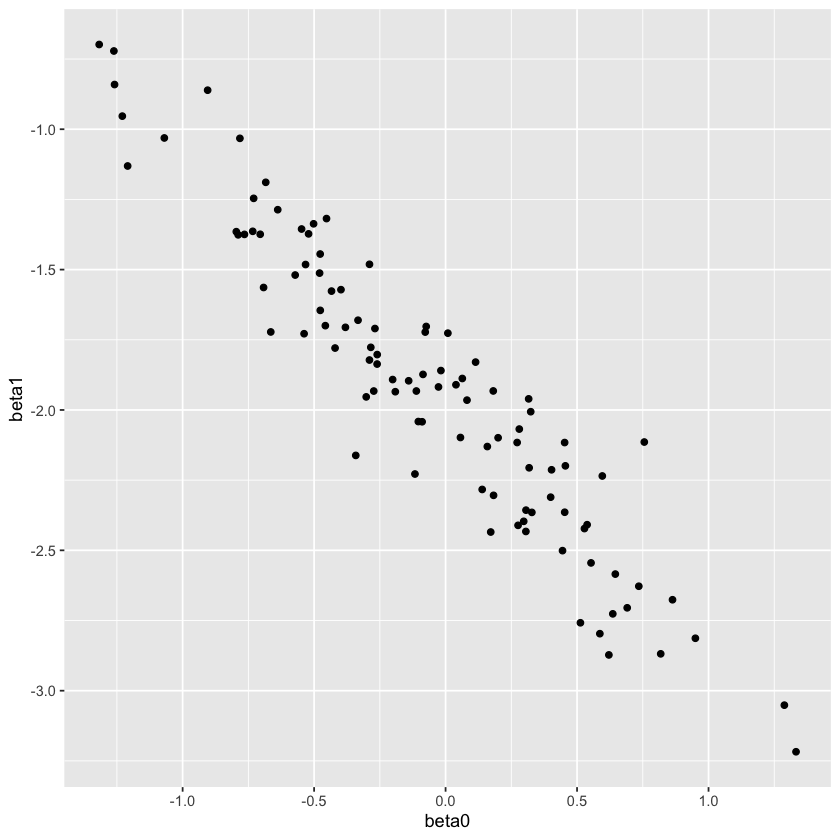

In [36]:
ggplot(param, aes(x=beta0, y=beta1)) + geom_point()

# 2. load simulation data

In [37]:
data <- read_feather('data/simulation_ebcr_1.feather')

In [38]:
data$date = as.Date("2022-01-01") + data$date

In [39]:
data = data %>% group_by(region) %>% group_modify(~ {
    data.frame(date = c(min(.x$date)+(-T0:-1), .x$date),
               death = c(rep(NA,T0), .x$death),
               intervention = c(rep(0,T0), .x$intervention))}
)

In [40]:
head(data)

region,date,death,intervention
<chr>,<date>,<int>,<dbl>
aa,2021-11-22,NA,0
aa,2021-11-23,NA,0
aa,2021-11-24,NA,0
aa,2021-11-25,NA,0
aa,2021-11-26,NA,0
aa,2021-11-27,NA,0


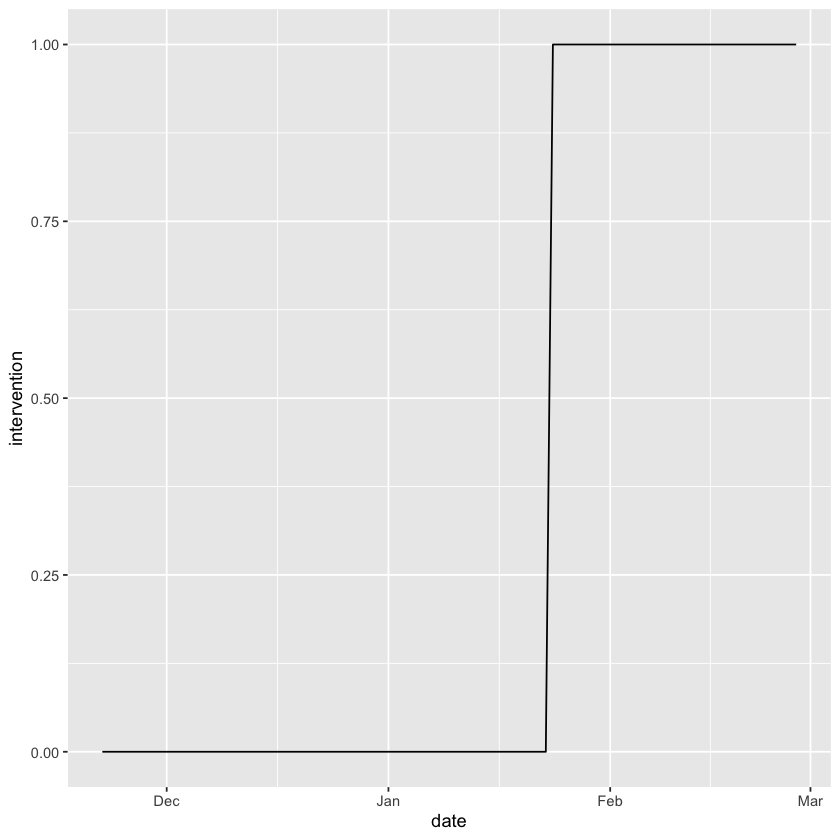

In [41]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=intervention)) + geom_line()

Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


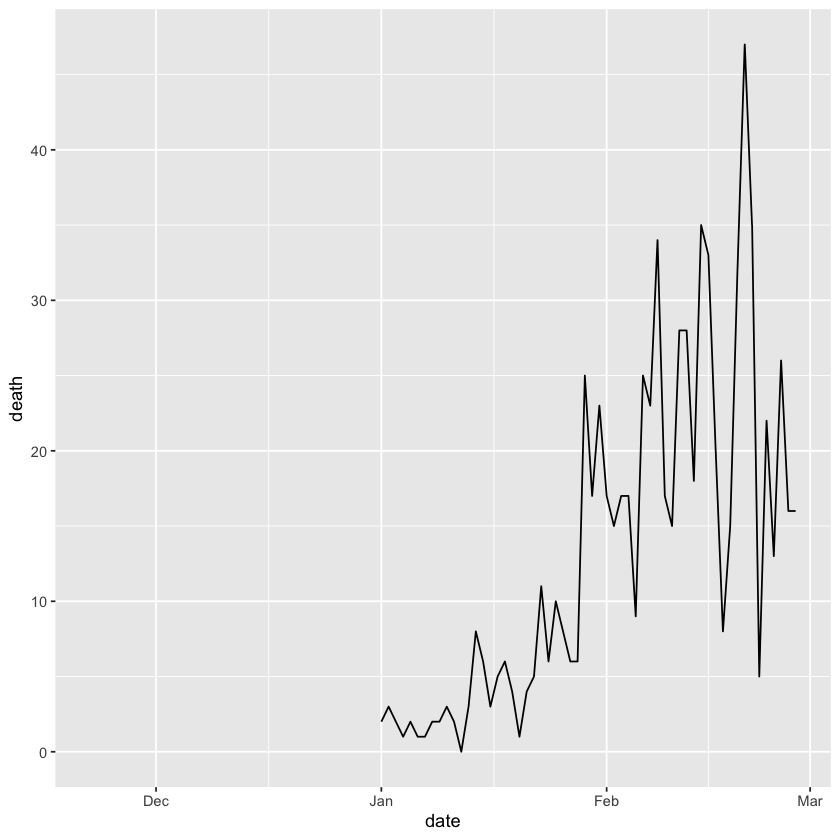

In [42]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=death)) + geom_line()

# 2. fit

In [43]:
rt <- epirt(formula = R(region, date) ~ 1 + intervention
            + (1 + intervention || region),
            prior = shifted_gamma(shape = 1/6, scale = 1, shift = log(1.05)/6),
            prior_covariance = decov(shape = c(2, 0.5), scale = 0.25),
            link = scaled_logit(K))

In [44]:
inf <- epiinf(gen = EuropeCovid$si, seed_days = T0)

In [45]:
deaths <- epiobs(formula = death ~ 1, i2o = EuropeCovid2$inf2death,
                 prior_intercept = normal(0, 0.01), link = scaled_logit(2*alpha))

Warning message:
“i2o does not sum to one. Please ensure this is intentional.”


In [46]:
args <- list(rt = rt, inf = inf, obs = deaths, data = data, 
             seed=12345, refresh=0)

In [47]:
args$algorithm <- "fullrank"; args$iter <- 5e4; args$tol_rel_obj <- 1e-3

In [48]:
fm <- do.call(epim, args)

Warning message:
“Pareto k diagnostic value is 17.22. Resampling is disabled. Decreasing tol_rel_obj may help if variational algorithm has terminated prematurely. Otherwise consider using sampling instead.”


In [49]:
as.data.frame(fm$stanfit)

R|(Intercept),R|intervention,R|b[(Intercept) region:aa],R|b[(Intercept) region:ab],R|b[(Intercept) region:ac],R|b[(Intercept) region:ad],R|b[(Intercept) region:ae],R|b[(Intercept) region:af],R|b[(Intercept) region:ag],R|b[(Intercept) region:ah],⋯,seeds[dp],seeds[dq],seeds[dr],seeds[ds],seeds[dt],seeds[du],seeds[dv],seeds_aux,death|reciprocal dispersion,log-posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.0419003,-1.54311,0.335081,-0.05511020,0.12354600,-0.584963,-0.445083,0.1139310,-0.406812,0.0913113,⋯,630.480,589.384,310.200,598.979,686.960,598.350,87.3943,222.1220,10.1202,0
-0.0243729,-1.88752,0.397434,0.11492600,0.28519800,-0.434687,-0.462997,0.0630250,-0.408323,0.2714270,⋯,772.501,664.394,472.458,846.094,759.459,633.189,45.7380,94.4143,10.0906,0
-0.0980715,-1.56382,0.389216,0.16779100,0.36290100,-0.550621,-0.461328,0.0752977,-0.281051,0.1257620,⋯,788.311,527.574,363.875,688.186,633.085,676.970,64.7045,223.6610,10.1707,0
-0.0895418,-2.18178,0.422242,0.05957010,0.41668700,-0.325851,-0.342654,0.3196580,-0.223234,0.3258870,⋯,659.297,615.549,379.032,1009.780,666.296,351.939,71.7243,108.8380,10.1324,0
-0.0861744,-1.62228,0.242926,-0.01778250,0.33542000,-0.397664,-0.296202,0.2138890,-0.376193,0.2426820,⋯,722.457,766.882,316.606,1077.640,730.008,621.506,122.4820,713.4190,10.1052,0
-0.2409820,-1.72226,0.336993,0.18844200,0.50334900,-0.459923,-0.230721,0.2896490,-0.348010,0.5680730,⋯,732.706,605.695,364.370,916.054,664.589,745.334,68.1080,237.6200,10.1065,0
-0.1141670,-1.69784,0.519518,0.02583950,0.30772200,-0.453496,-0.427056,0.1773050,-0.253422,0.3164820,⋯,863.424,611.733,440.554,799.592,662.669,585.485,83.1344,256.9310,10.1046,0
0.0892271,-1.77362,0.224874,0.02772060,0.04893270,-0.422422,-0.612685,0.0175041,-0.420039,0.3205520,⋯,730.032,551.245,291.687,969.596,659.928,548.352,61.6595,173.1120,10.2010,0
-0.1028050,-1.87988,0.398608,0.10791400,0.35249100,-0.259027,-0.380465,0.2971100,-0.379890,0.3055840,⋯,666.214,411.968,321.942,849.205,611.218,544.046,55.9616,103.6720,10.0953,0


In [50]:
write_feather(as.data.frame(fm$stanfit), 
              'result_epidemia_ebcr_1.feather')

## plots

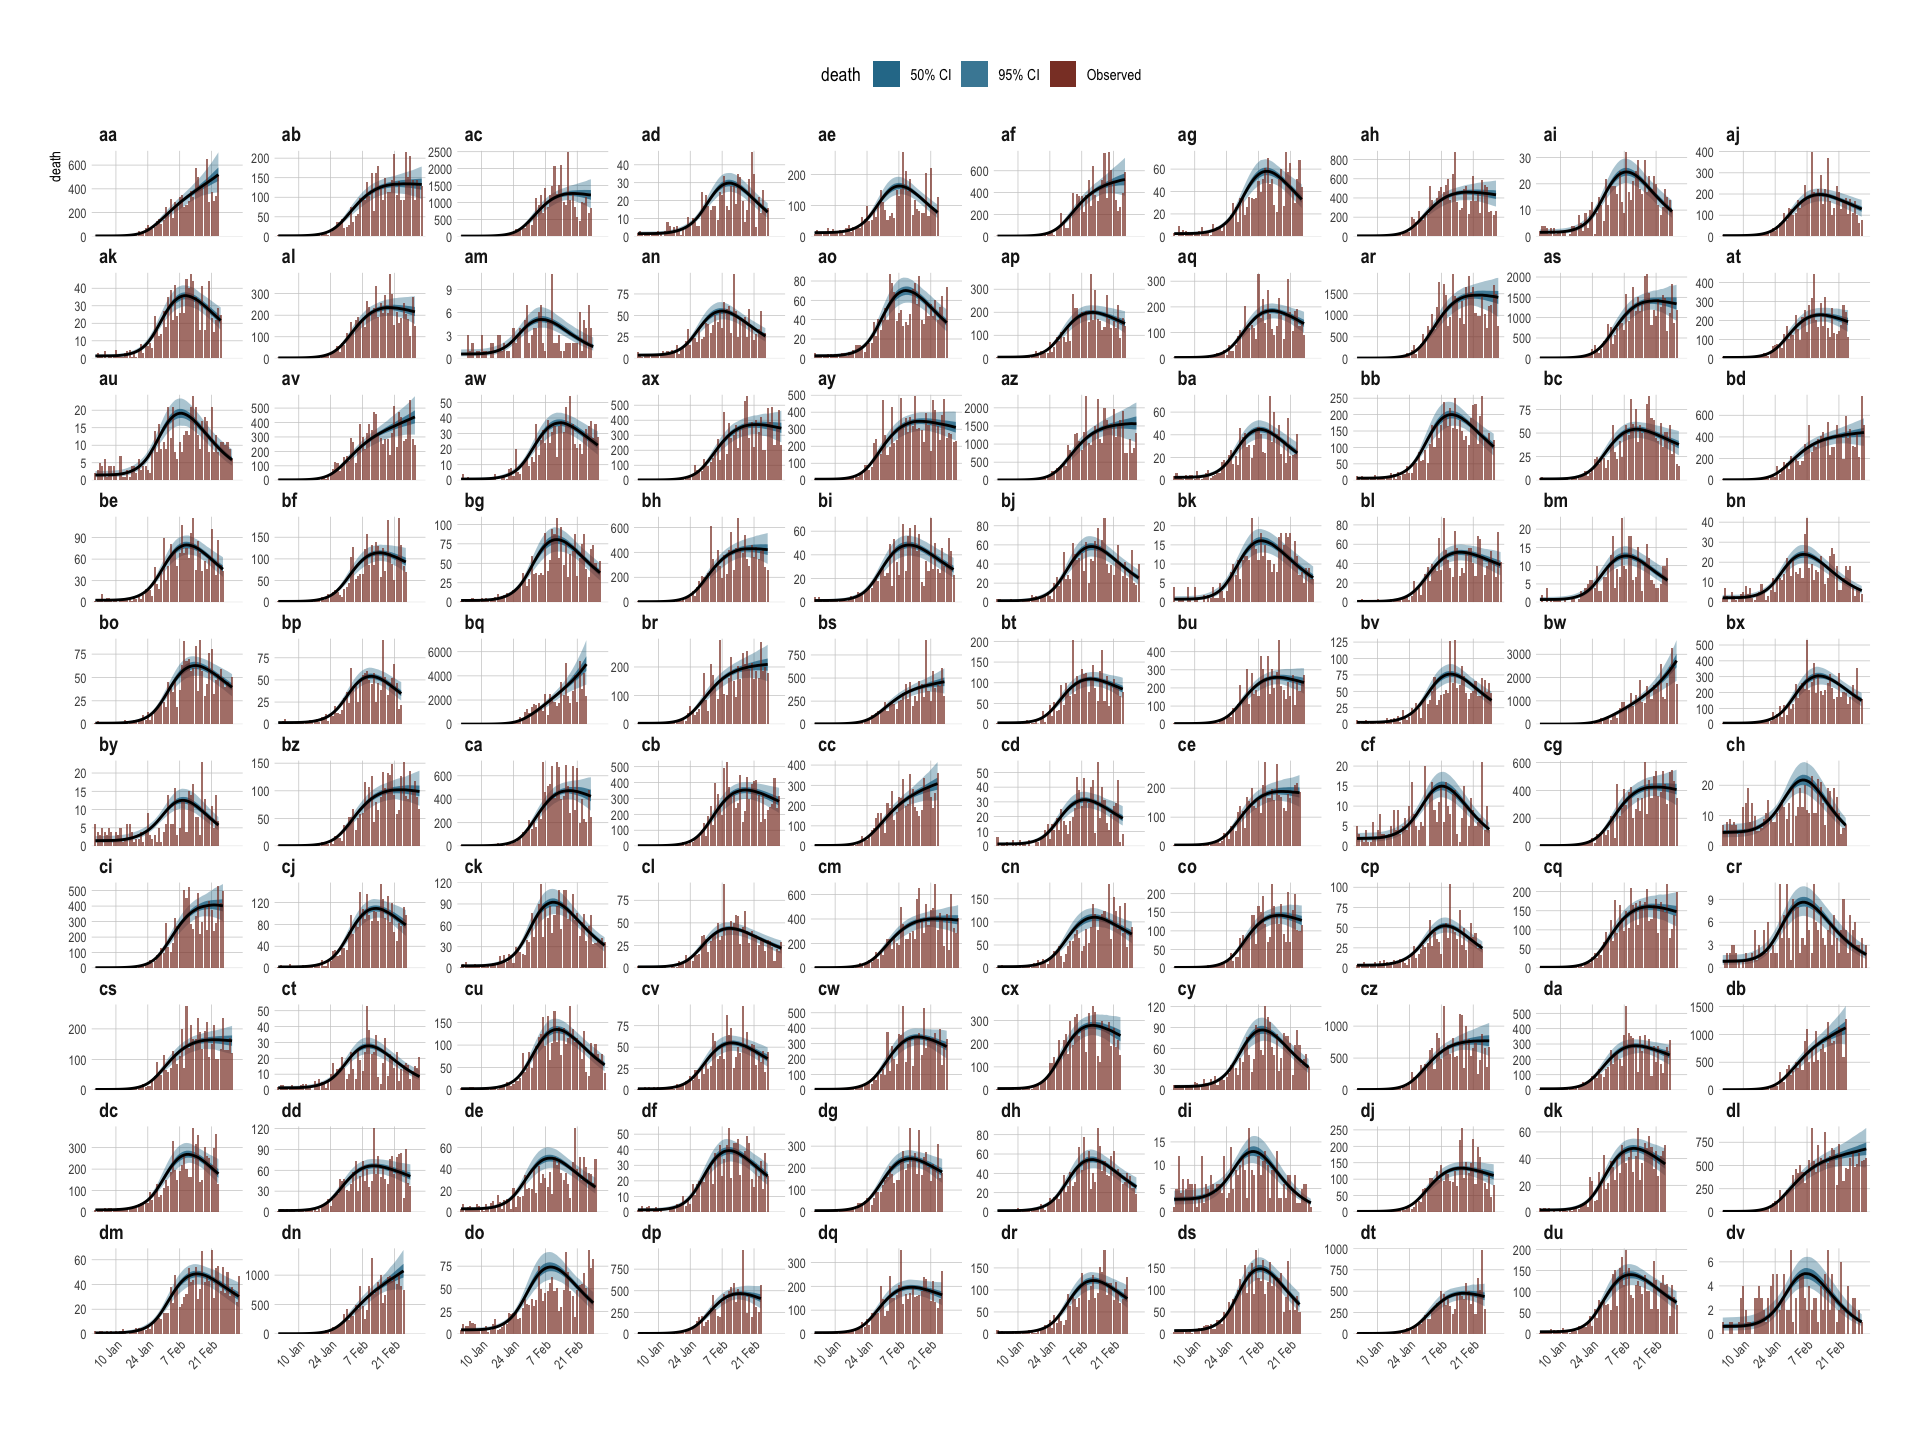

In [51]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="death", levels = c(50, 95), posterior_mean=TRUE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


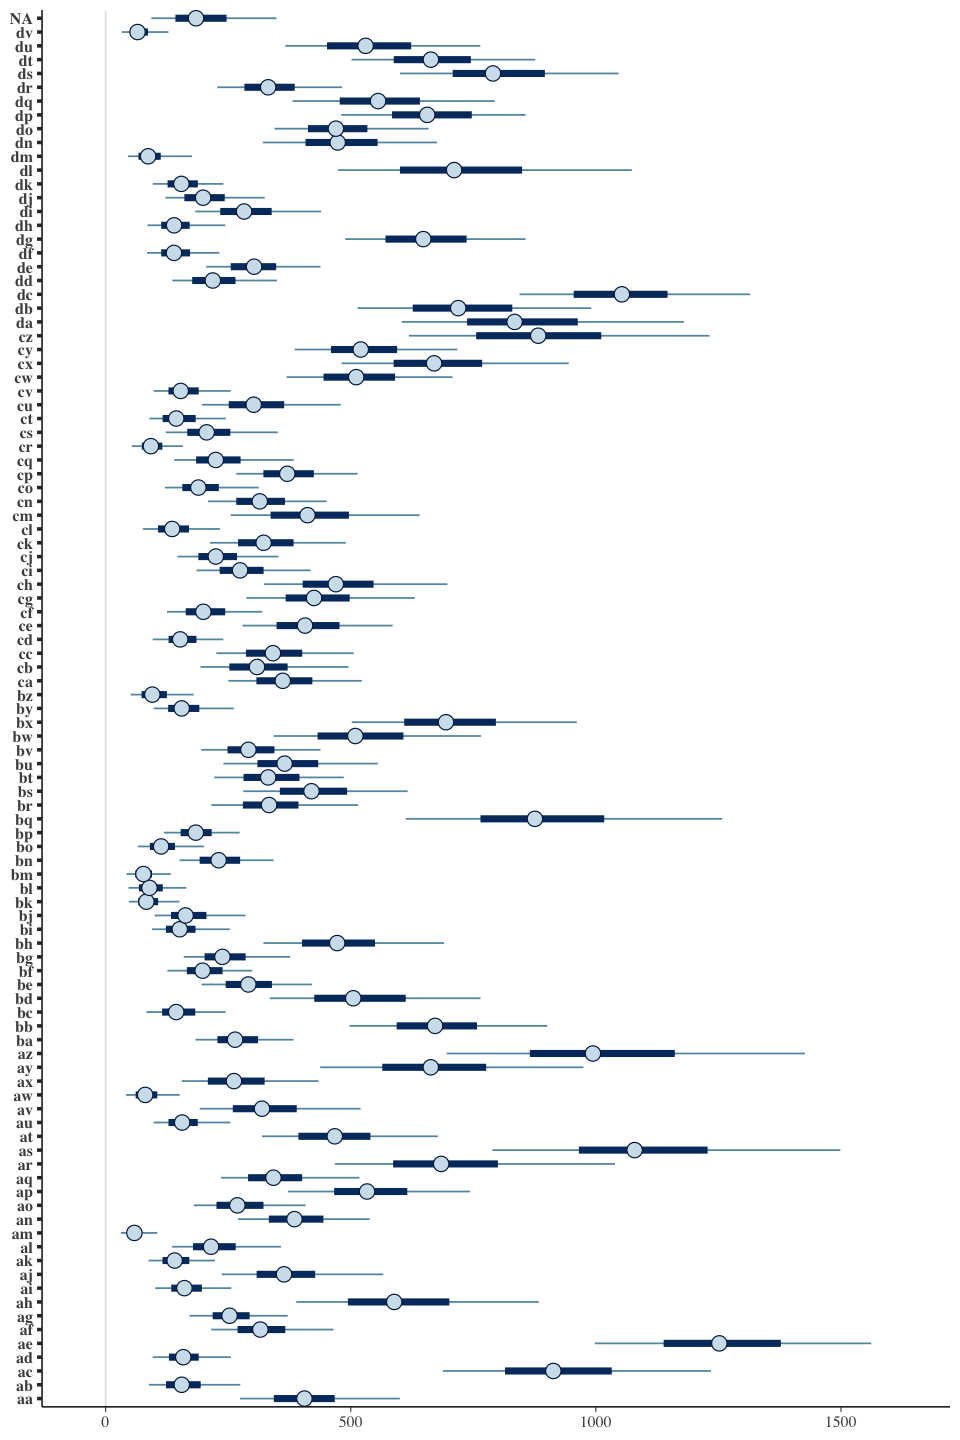

In [52]:
options(repr.plot.width = 8, repr.plot.height = 12)

mat <- as.matrix(fm, "areas", regex_pars = "seeds", par_groups = fm$groups)
bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [53]:
m_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


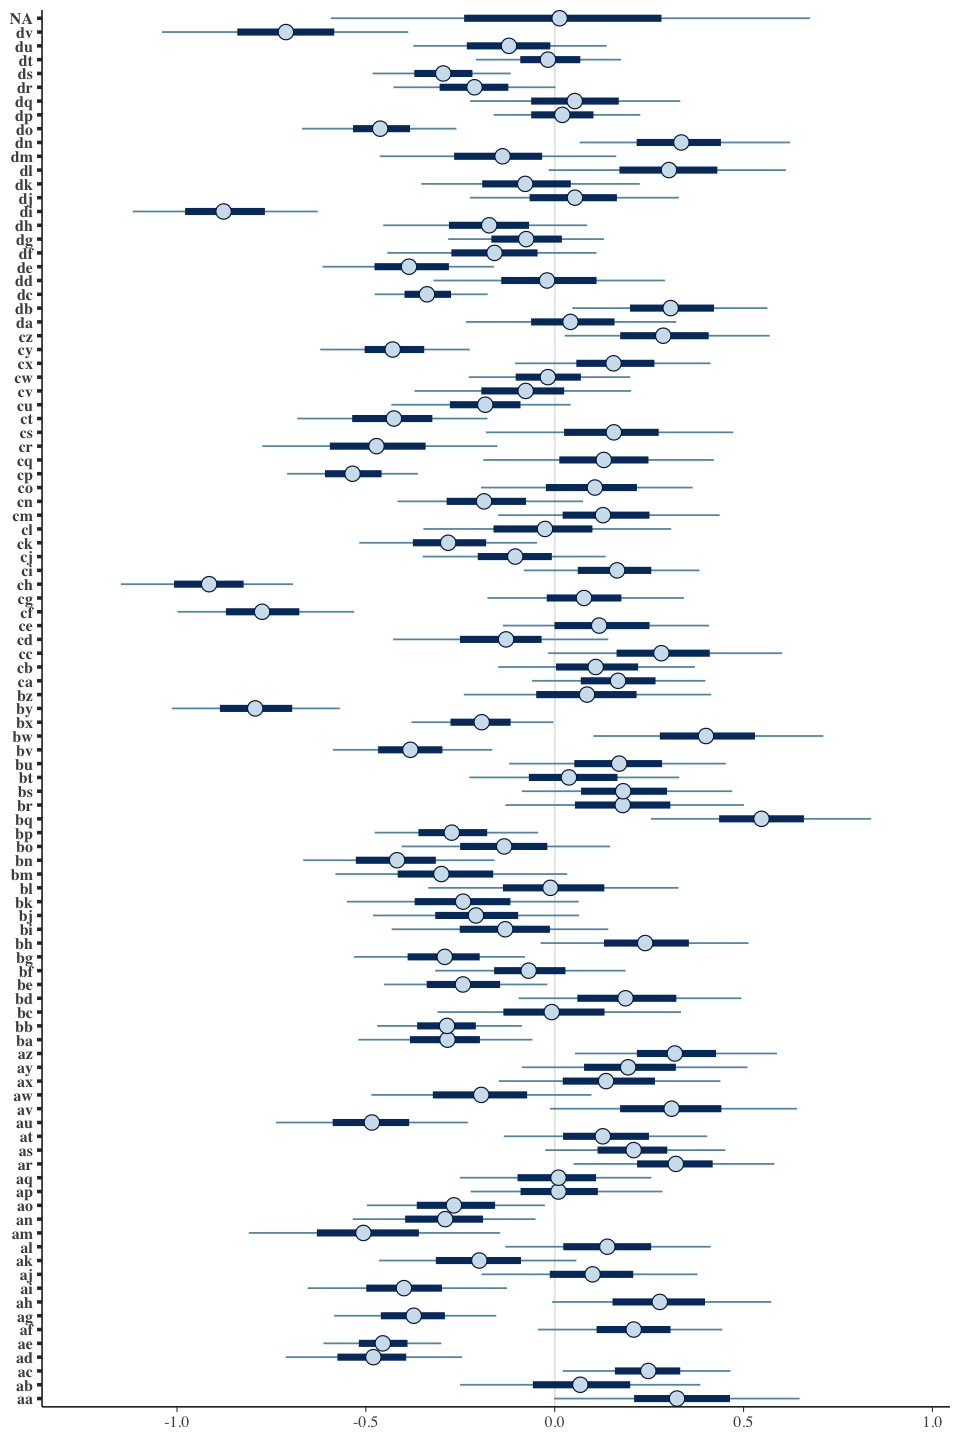

In [54]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|\\(Int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[\\(Int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [55]:
b0_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


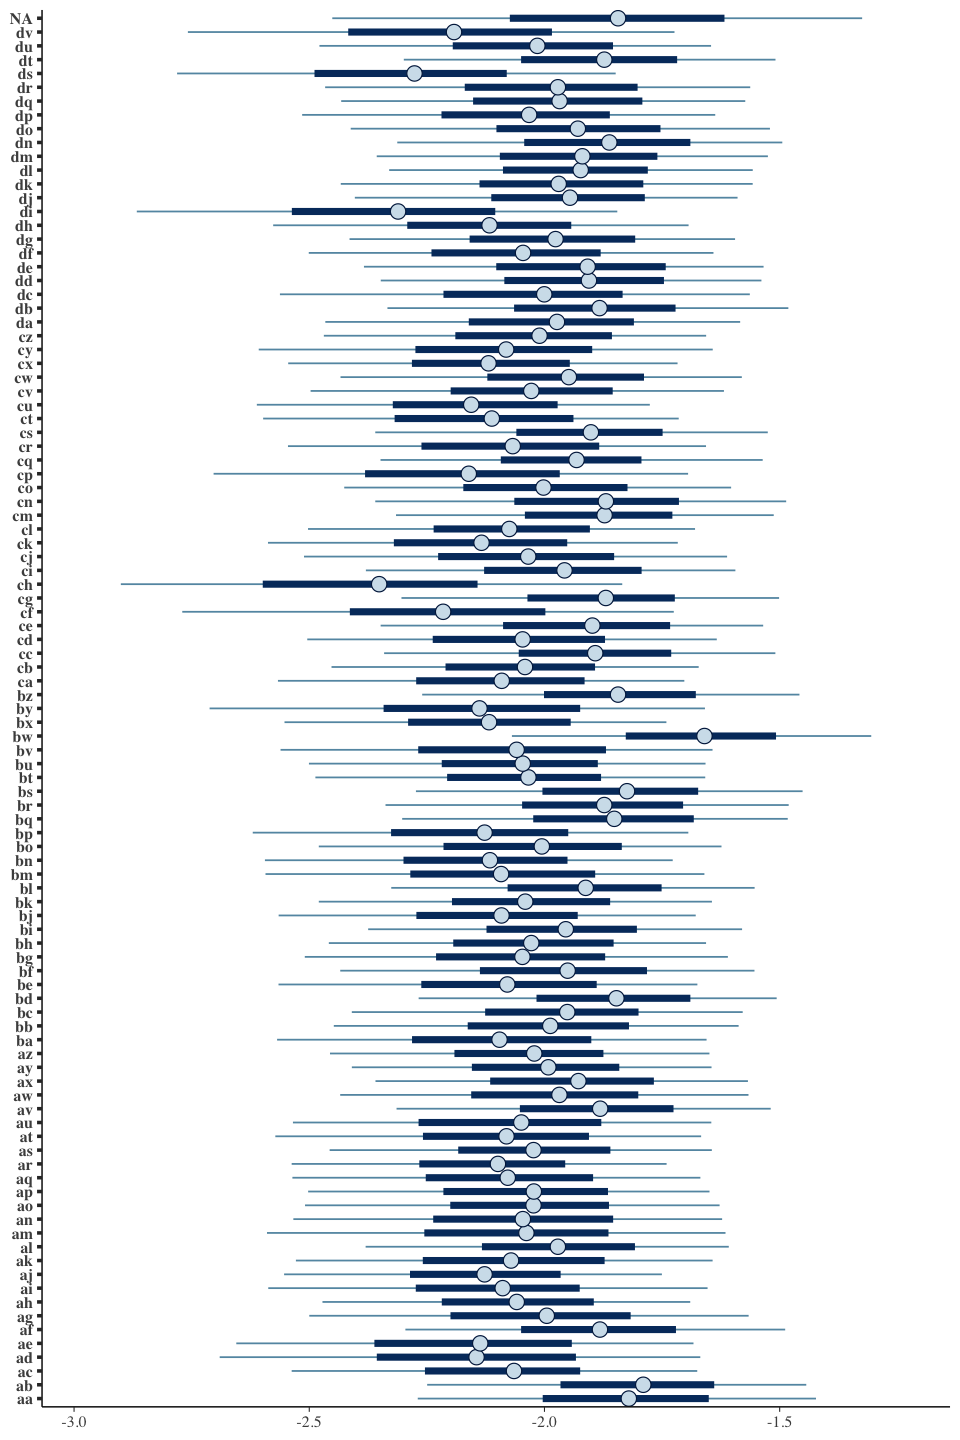

In [56]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [57]:
b1_epi = apply(mat, 2, mean)

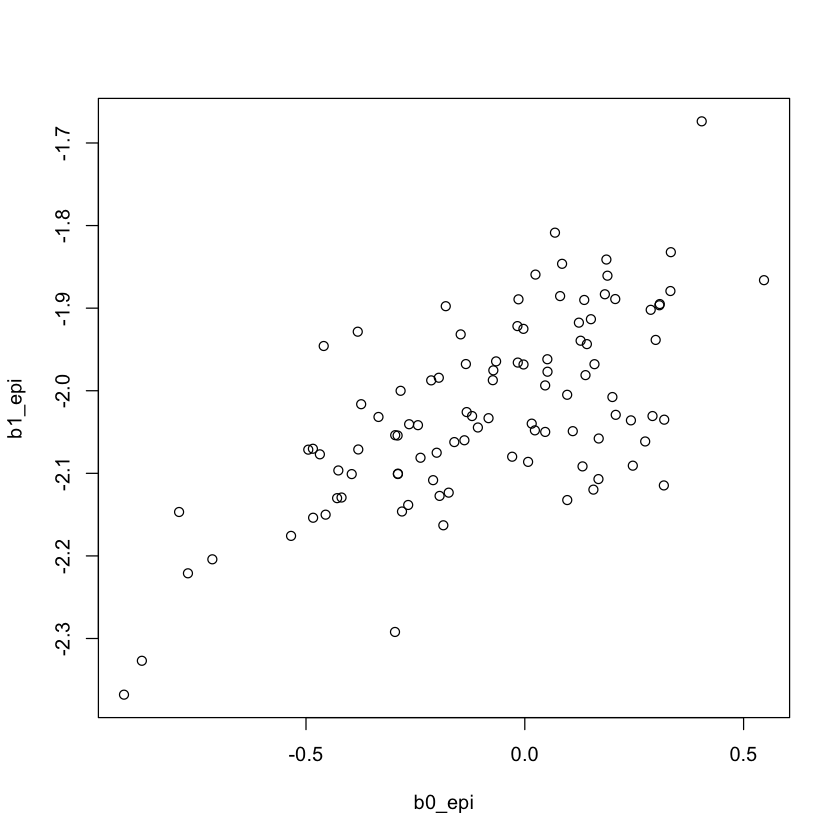

In [58]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(b0_epi, b1_epi)